[View in Colaboratory](https://colab.research.google.com/github/kaland313/vitmav45-ShipSeakers/blob/dataprep_cstp/Deep_Learning_big_home_assignment.ipynb)

# Deep learning big home assignment - Ship recognition

In this assignment we are going to recognise ships on the surface of the oceans and seas via satelite images.
You can find the kaggle challenge [here.](https://www.kaggle.com/c/airbus-ship-detection)



In [119]:
print("Hello World!")
#!mkdir train_img
#!mv *.jpg train_img
#!mkdir test_img
#!mv *.jpg test_img
#!rm -rf train_img test_img


Hello World!


In [0]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#from imageio import imread
from keras.utils import Sequence

%matplotlib inline

In [0]:
# functions
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    # create 2 dimensional array from 1D array   
    return img.reshape(shape).T  # Needed to align to RLE direction

def min_max(img_matrix, min=-1, max=1):
    return img_matrix/255.0 * (max - min) + min
  
def separate(train_data, valid_split=0.2):
    """
    
    Separate the dataset into 3 different part. Train, validation and test.
    train_data and test_data sets are 1D numpy arrays.

    returns the train, valid and test data sets
    
    """
    
    sum_ = train_data.shape[0]
    train = None
    valid = None
    
    train = train_data[:int(train_data.shape[0]*(1-valid_split))]
    valid = train_data[int(train_data.shape[0]*(1-valid_split)):]
    
    """
    TODO: it suppose to get more test data. Fix it.
    if int(sum_*test_split) == test_data.shape[0]:
        # exact amount test data in test dataset
        test = test_data
    elif int(sum_*test_split) > test_data.shape[0]:
        # need more test data from the train dataset
        test = test_data                                   # every data
        delta = int(sum_*test_split) - test_data.shape[0]  # how much more data needed 
        tmp_split = delta / (sum_-test_data.shape[0])      # in [0, 1]
    else:
        # too much data in the test dataset
        limit = int(test_data.shape[0] * (1 - test_split)) # index to split the test
        test = test_data[:limit]                           # get the test data
        tmp_split =  (1 - test_split)#1 - (test.shape[0] / test_data.shape[0])
        have_more_data = True
        
    if have_more_data:
        data = np.concatenate((train_data, test_data[int(test_data.shape[0]*tmp_split):]), axis=None)
        train = data[:int(data.shape[0]*(1-valid_split))]
        valid = data[int(data.shape[0]*(1-valid_split)):] # rest of the test_data is here
    else:        
        index_from = int(train_data.shape[0]*(1-tmp_split))
        
        test = np.concatenate((train_data[index_from:], test), axis=None)
        train = train_data[0:int(train_data.shape[0]*(valid_split))]
        valid = train_data[int(train_data.shape[0]*(valid_split)):index_from]
     """        
    return train, valid
  
def read_transform_image(img_file_path):
    img = mpimg.imread(img_file_path)
    #print(img)
    return min_max(img)
  
def DispImageWithMap(img_matrix, mask_matrix):
    fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
    axarr[0].axis("off")
    axarr[1].axis("off")
    axarr[2].axis("off")
    axarr[0].imshow(img_matrix)
    axarr[1].imshow(mask_matrix,cmap="Purples")
    axarr[2].imshow(img_matrix)
    axarr[2].imshow(mask_matrix, alpha=0.6,cmap="Purples")
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.show()

#ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(Sequence):
    
    def __init__(self, list_IDs, labels, img_path_prefix, batch_size=32, dim=(32,32,32),
                 n_channels=1, n_classes=10, shuffle=True):
        #Initialization
        self.dim = dim                              # dataset's dimension
        self.img_prefix = img_path_prefix           # location of the dataset
        self.batch_size = batch_size                # number of data/epoch
        self.labels = labels                        # "img":"rle mask" dictionary
        self.list_IDs = list_IDs                    # images filenames 
        self.n_channels = n_channels                # number of rgb chanels
        #self.n_classes = n_classes                 # ???
        self.shuffle = shuffle                      # shuffle the data
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        #Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        print("Ep end: {0}".format(self.indexes))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        #Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
      
    def __getitem__(self, index):
        # Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        print("getitem: {}".format(self.indexes))
        
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        print("getitem: {}".format(list_IDs_temp))
        
        # Generate data
        X, Y = self.generate(list_IDs_temp)

        return X, Y

    def generate(self, tmp_list):
        #Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        Y = np.empty((self.batch_size, *self.dim))
        #print(X.shape)
        #print(X)

        # Generate data
        for i, ID in enumerate(tmp_list):
            # read image called "ID"
            X[i] = read_transform_image(self.img_prefix+"/"+ID)
            
            #print("\n\n{}\n\n".format(X[i]))
            
            # store masks
            mask = rle_decode(labels[ID][0])
            Y[i] = mask

        return X, Y

I noticed there are lines with "nan". This means there are no ships on that picture. I put a characther in those spots, so I can identify these lines.

Also checked, if I put that character in those lines in the ImageId column. As we can see, every ImageId has some value, which is not "nan".

In [122]:
# reading the trainaing data and show the first 20 rows
df_train = pd.read_csv("train_ship_segmentations_v2.csv")
print(df_train.describe())
print(df_train.head(20))

swap_char = "0"
df_train = df_train.fillna(swap_char)

print("{0} features, {1} rows in the dataset.\n".format(df_train.values.shape[1], df_train.values.shape[0]))

ep_train = df_train.EncodedPixels.values # get every masks
image_ids_train = df_train["ImageId"].values # get every image ID's for later

for i in range(10):
    if ep_train[i] == swap_char:
        print("{}. is None!".format(i))
    else:
        print("{}. isn't None!".format(i))
        
print("\n{}\n".format(df_train.ImageId.isnull().describe()))


              ImageId                                      EncodedPixels
count          231723                                              81723
unique         192556                                              81722
top     ff7ac7f3c.jpg  43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq               15                                                  2
          ImageId                                      EncodedPixels
0   00003e153.jpg                                                NaN
1   0001124c7.jpg                                                NaN
2   000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3   000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4   000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5   000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6   000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7   000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8   0001b1832.

Little statistics about the data.

First, I check how many data are None. I count the None lines and I divide it by the sum of the lines. I call it None rate.



The number of None's = 150000. The number of data = 231723. None rate = 0.647


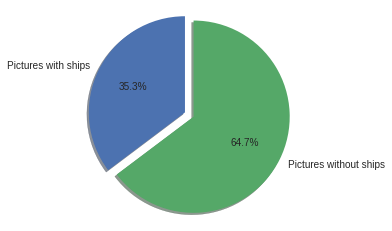

In [123]:
none_cnt = (df_train.EncodedPixels == swap_char).sum()
print(
    "The number of None's = {0}. The number of data = {1}. None rate = {2:.3f}"
     .format(none_cnt, len(ep_train), none_cnt/len(ep_train))
     )

labels = "Pictures with ships", "Pictures without ships"
sizes = [1-(none_cnt/len(ep_train)), none_cnt/len(ep_train)]
explode = (0, 0.1)  # only "explode" the 2nd slice

labels2 = "Train data", "Validation data"
sizes2 = [n_train/sum_, n_valid/sum_]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Szumma : 231723
Expected results:
Train: 196964, Valid: 34758


Szumma : 231723
Results:
Train: 196964, Valid: 34759




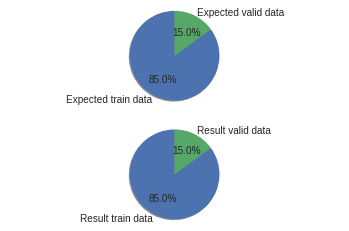

In [124]:
valid_split = 0.15

sum_ = image_ids_train.shape[0]
trn = int(sum_ * (1-valid_split))
van = int(sum_ * valid_split)

print("Szumma : {}".format(sum_))
print(
    "Expected results:\nTrain: {}, Valid: {}\n\n"
    .format(trn, van)
)

labels = "Expected train data", "Expected valid data"
sizes = [trn, van]

fig1, axes = plt.subplots(nrows=2)
axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

train, valid = separate(image_ids_train, valid_split)

sum_ = train.shape[0] + valid.shape[0]
trn = train.shape[0]
van = valid.shape[0]

print("Szumma : {}".format(sum_))
print(
    "Results:\nTrain: {}, Valid: {}\n\n"
    .format(trn, van)
)

labels2 = "Result train data", "Result valid data"
sizes2 = [trn, van]

axes[1].pie(sizes2, labels=labels2, autopct='%1.1f%%', shadow=True, startangle=90)
axes[1].axis('equal') 

plt.show()

In [125]:
# classification
img_id = image_ids_train[4]

#img = imread('../input/train/' + ImageId)
img_masks = df_train.loc[df_train["ImageId"] == img_id, "EncodedPixels"].tolist()

all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)

print(
    "{3}: Number of 1-s = {0}/{2}. Number of 0-s = {1}/{2}."
    .format(
        np.count_nonzero(all_masks),
        768**2-np.count_nonzero(all_masks),
        768**2,
        img_id
    )
)

000194a2d.jpg: Number of 1-s = 1460/589824. Number of 0-s = 588364/589824.


In [126]:
#debug, test
import os
X_debug_train = np.array(os.listdir("train_img"))
X_debug_test = np.array(os.listdir("test_img"))
print(
    "Train data size: {}, Test data size: {}"
    .format(X_debug_train.shape, X_debug_test.shape)
)

Train data size: (42,), Test data size: (21,)


35  -  7  -  21
Sum : 63
Results:
Train: 35, Valid: 7, Test: 21




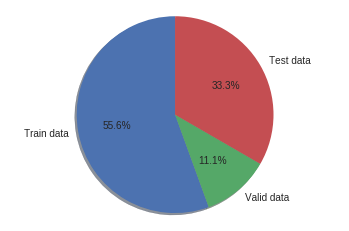

Ep end: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
Ep end: [0 1 2 3 4 5 6]
getitem: [27 28 24  8 14 34 20 22  4  3  2 10 12 18  6 31  1 17 33 30 16 13 15  5
 25 23  0 32 19 26  7 11  9 21 29]
getitem: ['000c150b0.jpg', '00a0969df.jpg']

Results are: 

(2, 768, 768, 3)
(2, 768, 768)
[[[-0.92941176 -0.71764706 -0.6627451 ]
  [-0.55294118 -0.35686275 -0.30196078]
  [-0.83529412 -0.63921569 -0.58431373]
  ...
  [-0.89803922 -0.70196078 -0.64705882]
  [-0.49019608 -0.29411765 -0.23921569]
  [-0.92941176 -0.73333333 -0.67843137]]

 [[-0.89019608 -0.69411765 -0.63921569]
  [-0.67058824 -0.4745098  -0.41960784]
  [-0.8745098  -0.67843137 -0.62352941]
  ...
  [-0.74117647 -0.54509804 -0.49019608]
  [-0.63137255 -0.43529412 -0.38039216]
  [-0.80392157 -0.60784314 -0.55294118]]

 [[-0.73333333 -0.5372549  -0.48235294]
  [-0.81960784 -0.62352941 -0.56862745]
  [-1.         -0.80392157 -0.74901961]
  ...
  [-0.69411765 -0.49803922 -0.

In [127]:
#data separation and generation test
valid_split = 0.15
train, valid = separate(X_debug_train, valid_split)
print(
    "{}  -  {}  -  {}"
    .format(
        img_train.shape[0],
        img_valid.shape[0],
        X_debug_test.shape[0]
    )
)

sum_ = train.shape[0] + valid.shape[0] + X_debug_test.shape[0]
trn = train.shape[0]
van = valid.shape[0]
ten = X_debug_test.shape[0]

print("Sum : {}".format(sum_))
print(
    "Results:\nTrain: {}, Valid: {}, Test: {}\n\n"
    .format(trn, van, ten)
)

# data visualization
labels = "Train data", "Valid data", "Test data"
sizes = [trn, van, ten]

fig1, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal') 

plt.show()

# dictionaries for the generators
partitions = {"train": img_train, "validation": img_valid}
# {"imgID1" : rle mask1, "imgID2" : rle_mask1, ... }  
labels = dict()

for i in range(X_debug_train.shape[0]):
    labels[X_debug_train[i]] = df_train.loc[df_train.ImageId == X_debug_train[i]].EncodedPixels.values
    
#print(labels[X_debug_train[5]][0])  # has rle mask
#print(labels[X_debug_train[12]][0]) # doesn't have rle mask

# ezeket majd a model.fit_generatot(...) függvényének adjuk át
rgb_channels_number = 3
dimension_of_the_image = (768, 768)
how_many_pictures_needed_per_epoch = 2

training_generator = DataGenerator(
    partitions["train"],
    labels,
    "train_img",
    batch_size=how_many_pictures_needed_per_epoch,
    dim=dimension_of_the_image,
    n_channels=rgb_channels_number
)

validation_generator = DataGenerator(
    partitions["validation"],
    labels,
    "train_img",
    batch_size=how_many_pictures_needed_per_epoch,
    dim=dimension_of_the_image,
    n_channels=rgb_channels_number
)

result = training_generator.__getitem__(4)
print("\nResults are: \n")
print(result[0].shape)
print(result[1].shape)
print(result[0][1])


In [128]:
rgb_channels_number = 3
dimension_of_the_image = (768, 768)
how_many_pictures_needed_per_epoch = 2

training_generator = DataGenerator(
    partitions["train"],
    labels,
    "train_img",
    batch_size=how_many_pictures_needed_per_epoch,
    dim=dimension_of_the_image,
    n_channels=rgb_channels_number
)

validation_generator = DataGenerator(
    partitions["validation"],
    labels,
    "train_img",
    batch_size=how_many_pictures_needed_per_epoch,
    dim=dimension_of_the_image,
    n_channels=rgb_channels_number
)
i = 0
for i in range(10):
    result = training_generator.__getitem__(i)
    #print(result[0].shape)
    #DispImageWithMap(result[0][0], result[1][0]) # between 0..1 !!! we have imgs in between -1..1

Ep end: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
Ep end: [0 1 2 3 4 5 6]
getitem: [ 0 18  2 23 29 16 12 25 10 33  3  9 14 27  8 31  4  1 30 34 28 11 22 19
 17 13 21 24 15  7 26 32 20  5  6]
getitem: ['000baef0c.jpg', '00a2dd872.jpg']
getitem: [ 0 18  2 23 29 16 12 25 10 33  3  9 14 27  8 31  4  1 30 34 28 11 22 19
 17 13 21 24 15  7 26 32 20  5  6]
getitem: ['00a52cd2a.jpg', '00a22caa9.jpg']
getitem: [ 0 18  2 23 29 16 12 25 10 33  3  9 14 27  8 31  4  1 30 34 28 11 22 19
 17 13 21 24 15  7 26 32 20  5  6]
getitem: ['00a694b3e.jpg', '000f7f2fd.jpg']
getitem: [ 0 18  2 23 29 16 12 25 10 33  3  9 14 27  8 31  4  1 30 34 28 11 22 19
 17 13 21 24 15  7 26 32 20  5  6]
getitem: ['000db3e62.jpg', '000fd9827.jpg']
getitem: [ 0 18  2 23 29 16 12 25 10 33  3  9 14 27  8 31  4  1 30 34 28 11 22 19
 17 13 21 24 15  7 26 32 20  5  6]
getitem: ['000bd9ac4.jpg', '00a5a195b.jpg']
getitem: [ 0 18  2 23 29 16 12 25 10 33  3  9 14 27  8 

#TODO
* Validációs adatok leválasztása (kfold, keras)
* Generátor fv  beolvassa a képeket, adat dúsít (forgatá, tükrözés)
   *  Szétválasztott adatok alapján beolvas képeket.
   * Dúsít
   * Képeket átalakít tömbbé
   * Dekódolja a maszkot
   * visszatér 2 tömbbel (standardizált adatok, minmax)
* Maszk Kódolás/Dekódolás (hajó nélküli képre is)
* keras megtanulása
  *   gen fv mágia
* Példa képek speciális esetekre megjelenítés, maszkolás
* Hajótlan képekre a dekoldoló fv (csupa 0 mátrix)
* Statisztika az adatokról
   * pie chart
   * hisztogrammok



    